In [1]:
from preprocessing_v3 import *
import evaluate
import numpy as np
import torch
from datasets import Dataset
from transformers import AdamW
import time
from transformers import Trainer, TrainingArguments
import evaluate
accuracy = evaluate.load("accuracy")

In [2]:
def compute_metrics(eval_pred):
    try:
        predictions, labels = eval_pred
    
        try:
            # Ensure predictions and labels are NumPy arrays to safely access their shape
            predictions = np.array(predictions)
            labels = np.array(labels)
            
            print(f"Predictions shape: {predictions.shape}")
            print(f"Labels shape: {labels.shape}\n")
            
        except AttributeError as e:
            print(f"Error accessing shapes: {e}")
            print(f"Predictions type: {type(predictions)}")
            print(f"Labels type: {type(labels)}")
            return {}
    
        # Handle case where data is smaller and not batched
        if len(predictions.shape) == 1:
            predictions = np.expand_dims(predictions, 0)  # Add batch dimension if missing
        
        if len(predictions.shape) > 2:
            # Apply a reduction if predictions have more than two dimensions (e.g., for sequence classification)
            predictions = predictions[:, 0, :]  # Take the first token's logits for each sequence
    
        # Convert logits to predicted labels
        predictions = np.argmax(predictions, axis=1)
    
        # Handle empty predictions or labels case
        if len(predictions) == 0 or len(labels) == 0:
            return {"accuracy": 0.0, "f1": 0.0, "recall": 0.0}
        
        # Handle case where there's only one class in the labels
        if len(np.unique(labels)) == 1:
            return {"accuracy": 1.0 if (predictions == labels).all() else 0.0}
    
        # Compute accuracy using a metric function
        return accuracy.compute(predictions=predictions, references=labels)
    except Exception as e:
        print(e)
        return {}

In [3]:
# Prepare the data, model, and tokenizer before training
preprocessor = preprocess('court_cases_headings_labels.csv')

label
0    2000
1    2000
2    2000
Name: count, dtype: int64
Added 36773 new tokens



In [4]:
preprocessor.prepare_LED_data()

Map:   0%|          | 0/5400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [5]:
BART_model, BART_tokenizer, train_data, eval_data = preprocessor.return_model_tokenizer_data()

Model configuration:  BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "rulings",
    "1": "facts",
    "2": "issues"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "facts": 1,
    "issues": 2,
    "rulings": 0
  },
  "max_position_embeddings": 128,
  "model_type": "bart",
  "normalize_before": fals

In [6]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=5e-5,  # Adjusted learning rate
    per_device_train_batch_size=8,  # Increased batch size
    per_device_eval_batch_size=8,    # Increased eval batch size
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy="steps",  # Evaluate every few steps
    eval_steps=500,         # Adjust evaluation frequency
    logging_steps=100,      # Adjust logging frequency
    load_best_model_at_end=True,
    fp16=True,              # Mixed precision training
    gradient_accumulation_steps=2,  # Simulate larger batch sizes
    dataloader_num_workers=4,  # For efficient data loading
)
trainer = Trainer(
    model=BART_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=BART_tokenizer,
    compute_metrics=compute_metrics,
)

In [10]:
eval_data

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 600
})

In [7]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=337, training_loss=1.0297713350471474, metrics={'train_runtime': 9177.872, 'train_samples_per_second': 0.588, 'train_steps_per_second': 0.037, 'total_flos': 413417600815104.0, 'train_loss': 1.0297713350471474, 'epoch': 0.9985185185185185})

In [8]:
# end of training

In [4]:
# Load the trained model and tokenizer from the saved directory
model_path = 'my_awesome_model/checkpoint-337' # Replace with your actual model path
model = BartForSequenceClassification.from_pretrained(model_path, ignore_mismatched_sizes=True)
tokenizer = BartTokenizer.from_pretrained(model_path)

# Prepare the input string
input_string = "WHEREAS, NCIP moved for a reconsideration of the CA Decision but was denied in a Resolution dated August 9, 2016"

# Tokenize the input
inputs = tokenizer(input_string, return_tensors="pt")

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted label (logits are raw predictions before softmax)
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=-1).item()

# Map the predicted class ID to the corresponding label
id2label = model.config.id2label
predicted_label = id2label[predicted_class_id]

# Output the result
print(f"Predicted label for '{input_string}': {predicted_label}")

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at my_awesome_model/checkpoint-337 and are newly initialized because the shapes did not match:
- model.decoder.embed_positions.weight: found shape torch.Size([1026, 768]) in the checkpoint and torch.Size([130, 768]) in the model instantiated
- model.encoder.embed_positions.weight: found shape torch.Size([1026, 768]) in the checkpoint and torch.Size([130, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label for 'WHEREAS, NCIP moved for a reconsideration of the CA Decision but was denied in a Resolution dated August 9, 2016': rulings


In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the trained model and tokenizer from the saved directory
model_path = 'my_awesome_model/checkpoint-337'  # Replace with your actual model path
model = BartForSequenceClassification.from_pretrained(model_path, ignore_mismatched_sizes=True)
tokenizer = BartTokenizer.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

# Prepare variables to collect predictions and labels
all_predictions = []
all_labels = []

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at my_awesome_model/checkpoint-337 and are newly initialized because the shapes did not match:
- model.decoder.embed_positions.weight: found shape torch.Size([1026, 768]) in the checkpoint and torch.Size([130, 768]) in the model instantiated
- model.encoder.embed_positions.weight: found shape torch.Size([1026, 768]) in the checkpoint and torch.Size([130, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Assuming eval_dataset is already loaded and tokenized
for example in eval_data:
    input_ids = example['input_ids'].unsqueeze(0)  # Add batch dimension (1, sequence_length)
    attention_mask = example['attention_mask'].unsqueeze(0)  # Add batch dimension (1, sequence_length)
    labels = example['labels']

    # Prepare inputs for the model
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
    }

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label (logits are raw predictions before softmax)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()  # Get scalar value

    # Store predictions and labels
    all_predictions.append(predicted_class_id)
    all_labels.append(labels)

Accuracy: 0.4600
F1 Score: 0.4603
Recall: 0.4600


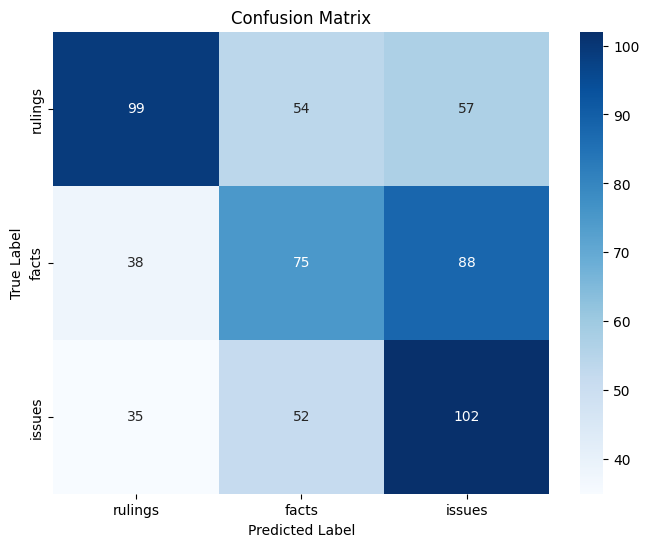

In [24]:
# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute accuracy, F1 score, and recall
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.config.id2label.values(), yticklabels=model.config.id2label.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()